[*********************100%%**********************]  1 of 1 completed


Epoch 1/25
26/26 [==============================] - 13s 45ms/step - loss: 0.0536
Epoch 2/25
26/26 [==============================] - 2s 63ms/step - loss: 0.0044
Epoch 3/25
26/26 [==============================] - 2s 77ms/step - loss: 0.0027
Epoch 4/25
26/26 [==============================] - 2s 87ms/step - loss: 0.0021
Epoch 5/25
26/26 [==============================] - 2s 86ms/step - loss: 0.0020
Epoch 6/25
26/26 [==============================] - 2s 87ms/step - loss: 0.0019
Epoch 7/25
26/26 [==============================] - 2s 81ms/step - loss: 0.0019
Epoch 8/25
26/26 [==============================] - 2s 78ms/step - loss: 0.0018
Epoch 9/25
26/26 [==============================] - 2s 71ms/step - loss: 0.0018
Epoch 10/25
26/26 [==============================] - 2s 79ms/step - loss: 0.0018
Epoch 11/25
26/26 [==============================] - 2s 86ms/step - loss: 0.0017
Epoch 12/25
26/26 [==============================] - 2s 87ms/step - loss: 0.0016
Epoch 13/25
26/26 [=================

[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 1s 909ms/step
    Real Prices  Predicted Prices Real Direction Predicted Direction  \
0    173.500000        179.938126              ↓                   ↓   
1    171.770004        179.498871              ↓                   ↓   
2    173.559998        178.385101              ↑                   ↓   
3    173.750000        177.185593              ↑                   ↓   
4    172.570007        176.072632              ↓                   ↓   
5    172.070007        174.997589              ↓                   ↓   
6    172.070007        174.015945              ↓                   ↓   
7    172.690002        173.207047              ↑                   ↓   
8    175.050003        172.673630              ↑                   ↓   
9    175.160004        172.654892              ↑                   ↓   
10   174.199997        172.970734              ↓                   ↑   
11   171.559998        173.357315              ↓                   ↑   
12   171.83

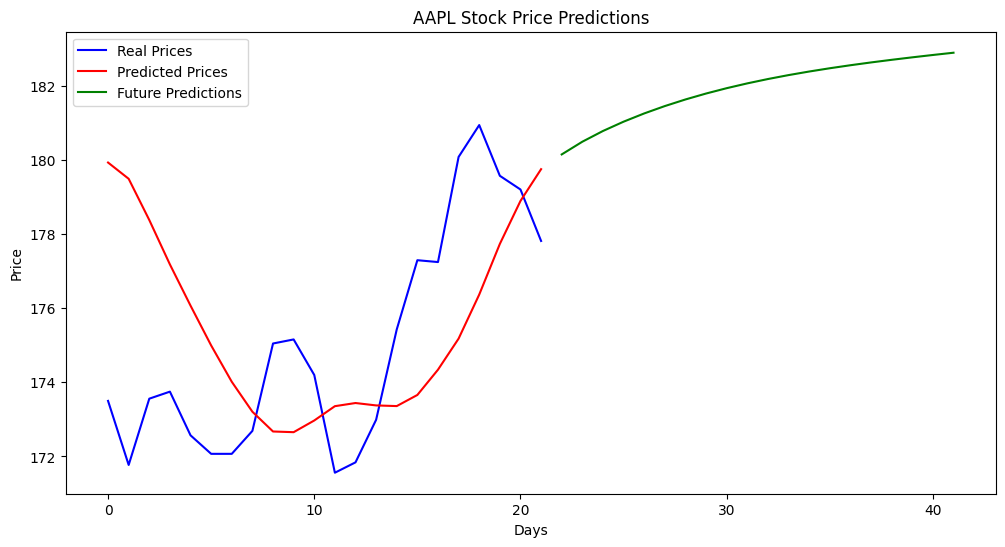

In [1]:
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Descargamos los datos históricos
data = yf.download('AAPL', start='2020-01-01', end='2023-06-08')

if data.empty:
    raise ValueError("No se pudieron descargar los datos. Verifica la conexión a Internet o el ticker de la acción.")

# Preprocesamiento y escalamiento
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

# Preparamos los datos para LSTM
prediction_days = 60
x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Creamos la Red Neuronal LSTM
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

# Predicción
test_start = '2023-05-08'
test_end = '2023-06-08'
test_data = yf.download('AAPL', start=test_start, end=test_end)
if test_data.empty:
    raise ValueError("No se pudieron descargar los datos de prueba. Verifica la conexión a Internet o el ticker de la acción.")

actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Crear un DataFrame para comparar los precios reales y los predichos
df = pd.DataFrame(data={'Real Prices': actual_prices, 'Predicted Prices': predicted_prices.flatten()})

# Calcular las direcciones (up o down)
df['Real Direction'] = df['Real Prices'].diff().apply(lambda x: '↑' if x > 0 else '↓')
df['Predicted Direction'] = df['Predicted Prices'].diff().apply(lambda x: '↑' if x > 0 else '↓')

# Verificar si las direcciones coinciden
df['Direction Match'] = df.apply(lambda row: '✓' if row['Real Direction'] == row['Predicted Direction'] else 'x', axis=1)

print(df)

# Métricas de evaluación
mae = mean_absolute_error(df['Real Prices'], df['Predicted Prices'])
rmse = np.sqrt(mean_squared_error(df['Real Prices'], df['Predicted Prices']))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

# Predicción para los próximos 20 días
future_days = 20
x_future = model_inputs[-prediction_days:].reshape(1, prediction_days, 1)
predictions_future = []

for _ in range(future_days):
    prediction = model.predict(x_future)
    predictions_future.append(prediction[0][0])
    x_future = np.append(x_future[:,1:,:], prediction.reshape(-1, 1, 1), axis=1)

# Des-escalar los valores predichos
predictions_future = scaler.inverse_transform(np.array(predictions_future).reshape(-1, 1))

print("\nPredicciones para los próximos 20 días:")
print(predictions_future)

# Graficar las predicciones
plt.figure(figsize=(12,6))
plt.plot(range(len(df)), df['Real Prices'], color='blue', label='Real Prices')
plt.plot(range(len(df)), df['Predicted Prices'], color='red', label='Predicted Prices')
plt.plot(range(len(df), len(df) + future_days), predictions_future, color='green', label='Future Predictions')
plt.title('AAPL Stock Price Predictions')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()
